# Исследование объявлений о продаже квартир

На основе архивных данных о продаже квартир в Санкт-Петербурге и Ленинградской области необходимо выяснить, как влияют на стоимость недвижимости следующие факторы:
- количество комнат;
- высота потолков;
- площадь квартиры;
- расположение квартиры;
- дата размещения объявления

## Изучение данных из файла

Для начала импортируем библиотеки, которые пригодятся в процессе анализа.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [2]:
real_estate_data = pd.read_csv('real_estate_data.csv', sep='\t')
real_estate_data.rename(columns={'cityCenters_nearest': 'city_centers_nearest'}, inplace=True)

real_estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

При изучении данных обнаружены пропуски в столбцах `ceiling_height`, `floors_total`, `living_area`, `is_apartment`, `kitchen_area`, `balcony`, `locality_name`, `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around`, `ponds_nearest` и `days_exposition`, то есть более, чем в половине столбцов.

Столбцы `first_day_exposition` и `is_apartment` имеют тип `object`, хотя в первом случае это даты, а во втором — ответы «да» и «нет» (столбец должен быть булевым, но из-за пропусков тип другой). Столбец `floors_total` имеет тип `float`, хотя этажей не может быть, например, 2.5.

## Предобработка данных
### Работа с пропусками

Заменим отсутствующие значения в столбце `balcony` нулями, потому что, скорее всего, в квартирах, где площадь балкона не указана, балкона просто нет. То же со столбцом `is_apartment`: если не сказано, что недвижимость — апартаменты, значит она — не апартаменты. Рискну предположить, что так же дела обстоят и со столбцами `parks_around3000` и `ponds_around3000`.

Пропусков в столбце `locality_name` мало (49 штук, это меньше 0.2%), а для анализа нам важны данные по географии квартир, поэтому придумывать, чем заполнить пропуски, не будем, а просто отбросим строки, в которых нет указания локации.

Пропуски в столбце `living_area` заменим средним значением по квартирам с той же общей площадью и количеством комнат. Аналогично поступим с пропусками в столбце `kitchen_area`.

Пропуски в столбце `days_exposition` скорее всего означают, что квартира еще не продана, т.е. объявление актуально. Логичнее сохранить пропуски.

Замену для оставшихся пропусков в столбцах предположить и заполнить нельзя, потому что выдуманные данные сильно испортят анализ. Оставим их как есть.

In [3]:
real_estate_data['balcony'] = real_estate_data['balcony'].fillna(0)

real_estate_data['parks_around3000'] = real_estate_data['parks_around3000'].fillna(0)

real_estate_data['ponds_around3000'] = real_estate_data['ponds_around3000'].fillna(0)

real_estate_data['is_apartment'] = real_estate_data['is_apartment'].fillna(False)

real_estate_data.dropna(subset=['locality_name'], inplace=True)

real_estate_data['total_area'] = real_estate_data['total_area'].round()

gb = real_estate_data.groupby(['total_area','rooms'])
real_estate_data['living_area'] = real_estate_data['living_area'].fillna(gb['living_area'].transform(lambda group: group.mean() / (group.name[0])) * real_estate_data['total_area'])

real_estate_data['kitchen_area'] = real_estate_data['kitchen_area'].fillna(gb['kitchen_area'].transform(lambda group: group.mean() / (group.name[0])) * real_estate_data['total_area'])

real_estate_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        14490 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23598 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  bool   
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23399 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

### Изменение типов данных

Изменим тип данных в столбце `first_day_exposition` на `datetime`.

В столбцах `parks_around3000` и `ponds_around3000` изменим тип данных на `int`.

In [4]:
real_estate_data['first_day_exposition'] = pd.to_datetime(real_estate_data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

real_estate_data['parks_around3000'] = real_estate_data['parks_around3000'].astype('int')

real_estate_data['ponds_around3000'] = real_estate_data['ponds_around3000'].astype('int')

real_estate_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  float64       
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        14490 non-null  float64       
 6   floors_total          23565 non-null  float64       
 7   living_area           23598 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23399 non-null  float64       
 13  balcony         

## Расчёты и добавление результатов в таблицу

Добавим в таблицу столбец `square_meter_price` и заполним, разделив цену каждой квартиры на ее площадь. Затем добавим столбец с днем недели, в который было размещено оъявление. Далее для анализа нам потребуются столбцы, в которых будет указан только год или только месяц публикации объявления (чтобы отследить тенденции на рынке недвижимости по месяцам, например).

Соотношения жилой площади к общей и кухни к общей площади выведем в процентах.

In [5]:
real_estate_data['square_meter_price'] = real_estate_data['last_price'] / real_estate_data['total_area']

real_estate_data['fde_weekday'] = real_estate_data['first_day_exposition'].dt.weekday

real_estate_data['year_grouped'] = pd.DatetimeIndex(real_estate_data['first_day_exposition']).year

real_estate_data['month_grouped'] = pd.DatetimeIndex(real_estate_data['first_day_exposition']).month

def floors_func(row):
    if row['floor'] == 1:
        return 1 
    if row['floor'] == row['floors_total']:
        return 3 
    return 2

real_estate_data['floor_grouped'] = real_estate_data.apply(floors_func, axis=1)

real_estate_data['living_area_scale'] = real_estate_data['living_area'] / real_estate_data['total_area'] * 100

real_estate_data['kitchen_area_scale'] = real_estate_data['kitchen_area'] / real_estate_data['total_area'] * 100

real_estate_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,fde_weekday,year_grouped,month_grouped,floor_grouped,living_area_scale,kitchen_area_scale
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.370370,3,2019,3,2,47.222222,23.148148
1,7,3350000.0,40.0,2018-12-04,1,NaN,11.0,18.6,1,False,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,83750.000000,1,2018,12,1,46.500000,27.500000
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.714286,3,2015,8,2,61.250000,14.821429
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,54.0,9,False,False,False,15.0,0.0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,408176.100629,4,2015,7,2,33.962264,9.433962
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,False,False,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.000000,1,2018,6,2,32.000000,41.000000


## Исследовательский анализ данных

In [6]:
real_estate_data['total_area'].describe()

count    23650.000000
mean        60.321818
std         35.665215
min         12.000000
25%         40.000000
50%         52.000000
75%         70.000000
max        900.000000
Name: total_area, dtype: float64

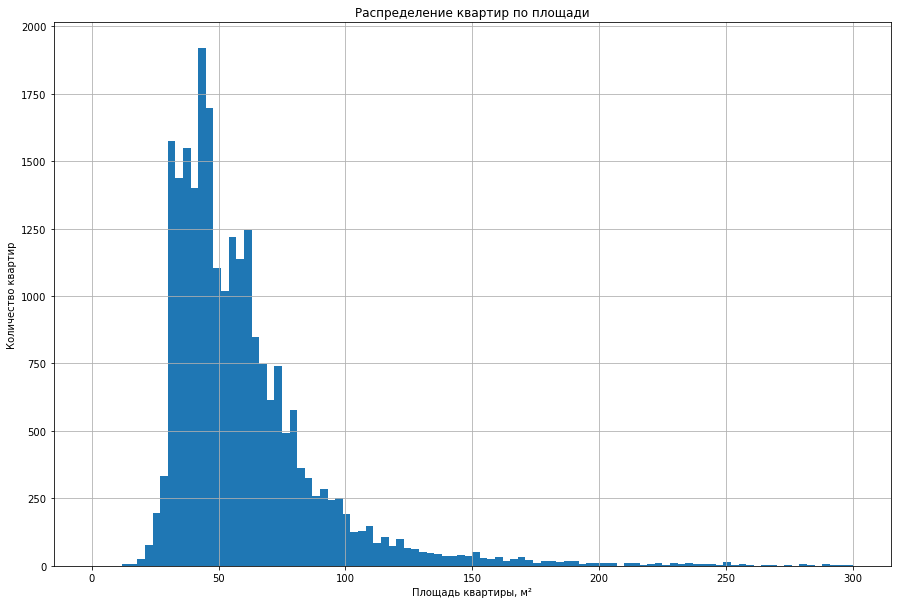

In [7]:
real_estate_data['total_area'].hist(bins=100, range=(0, 300), figsize=(15, 10))
plt.xlabel('Площадь квартиры, м²')
plt.ylabel('Количество квартир')
plt.title('Распределение квартир по площади')
plt.show()

В таблице встречаются квартиры от 12 до 900 м², при том, что последний квартиль — 70 м² (значит, квартир с огромными площадями очень мало). Средняя площадь квартир по столбцу — 60 м². Медиана — 50 м².

In [8]:
real_estate_data['convenient_price'] = real_estate_data['last_price'] / 1000000

real_estate_data['convenient_price'].describe()

count    23650.000000
mean         6.541127
std         10.896399
min          0.012190
25%          3.400000
50%          4.650000
75%          6.799000
max        763.000000
Name: convenient_price, dtype: float64

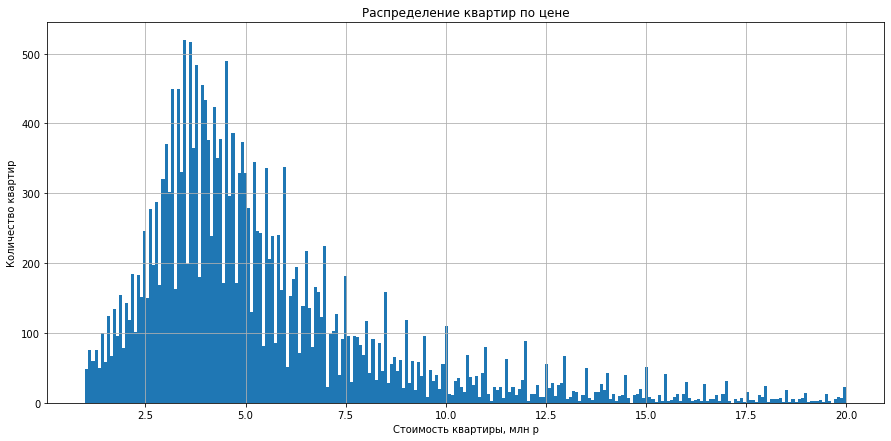

In [9]:
real_estate_data['convenient_price'].hist(bins=250, range=(1, 20), figsize=(15, 7))
plt.xlabel('Стоимость квартиры, млн р')
plt.ylabel('Количество квартир')
plt.title('Распределение квартир по цене')
plt.show()

В таблице встречаются квартиры стоимостью от 12.190 тыс до 763 млн рублей. Крайние значения неадекватны (в России нигде и никакую квартиру нельзя купить за 12 тыс рублей, а последний квартиль — меньше 7 млн, то есть действительно дорогих квартир в таблице мало), поэтому для гистограммы возьмем выборку от одного до двадцати млн.

Средняя стоимость квартиры в таблице — 6,5 млн р. Медиана — 4,65 млн р.

In [10]:
real_estate_data['rooms'].describe()

count    23650.000000
mean         2.070106
std          1.078620
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

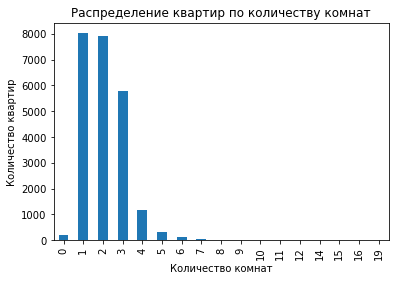

In [11]:
real_estate_data['rooms'].value_counts().sort_index().plot.bar()
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир')
plt.title('Распределение квартир по количеству комнат')
plt.show()

Максимальное число комнат в таблице — 19. Это либо выкупленный целиком этаж дома, либо _если бы мы знали, что это такое, но мы не знаем, что это такое_. Среднее значение и медиана очень близки: 2.07 и 2.0 соответственно. Это говорит о том, что выбросов почти нет.

Гистограмма показывает, что однокомнатных и двухкомнатных квартир в таблице больше всего (и тех и других около 8 тысяч, с небольшим разрывом почти в 100 штук в пользу однокомнатных). Трехкомнатных квартир в таблице почти 6 тысяч. Остальных значительно меньше.

In [12]:
real_estate_data['ceiling_height'].describe()

count    14490.000000
mean         2.771287
std          1.261593
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

AxesSubplot(0.125,0.125;0.775x0.755)


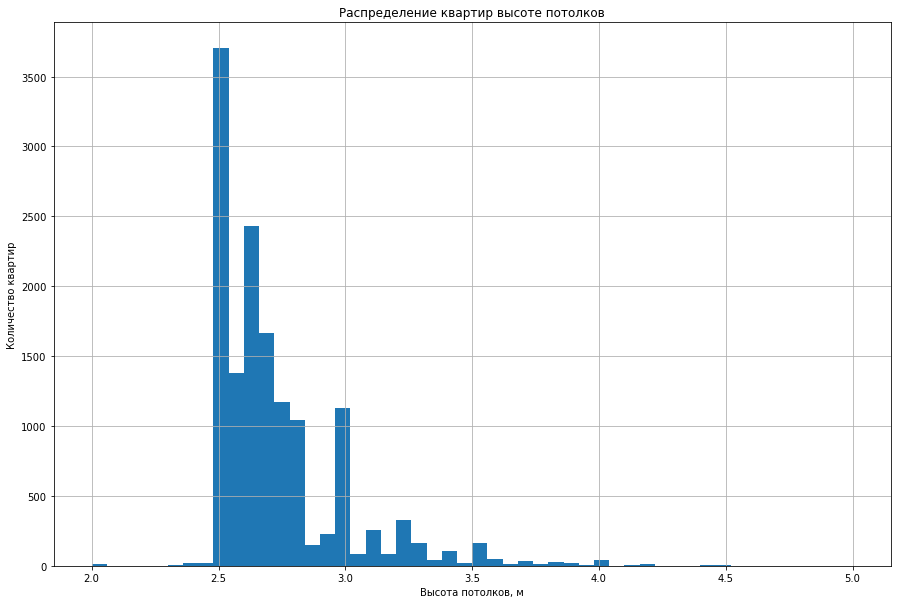

In [13]:
print(real_estate_data['ceiling_height'].hist(bins=50, range=(2, 5), figsize=(15, 10)))
plt.xlabel('Высота потолков, м')
plt.ylabel('Количество квартир')
plt.title('Распределение квартир высоте потолков')
plt.show()

В таблце есть совершенно очаровательные квартиры с заявленной высотой потолков от 1 до 100 м. Среднее значение — 2.77 м, медиана — 2.65 м.

Для гистограммы выберем только реалистичные показатели (от 2 до 5 метров, учитывая «сталинки» с потолками в 3.7 метра и больше). Гистограмма показывает, что большинство квартир имеет высоту потолков 2.5 м (то есть, большинство квартир — «хрущевки»).

In [14]:
real_estate_data['days_exposition'].describe()

count    20470.000000
mean       180.753200
std        219.777916
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

AxesSubplot(0.125,0.125;0.775x0.755)


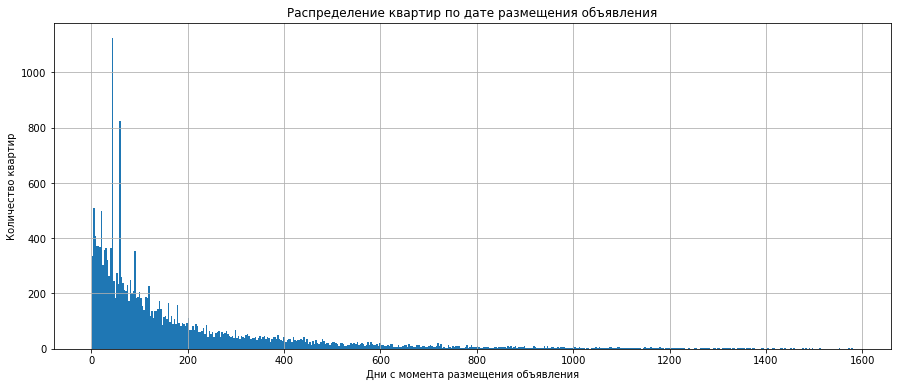

In [15]:
print(real_estate_data['days_exposition'].hist(bins=500, figsize=(15, 6)))
plt.xlabel('Дни с момента размещения объявления')
plt.ylabel('Количество квартир')
plt.title('Распределение квартир по дате размещения объявления')
plt.show()

В таблице встречаются объявления, размещенные от 1 до 2478 дней (больше 6 лет) назад. Медианное значение по столбцу — 124 дня (около 4 месяцев). Среднее — 301 день (около 10 месяцев). Такая разница между медианой и средним говорит о наличии частых выбивающихся значений. На самом деле и среднее и медиана — вполне реалистичные цифры, потому что время продажи зависит от многих факторов, которые мы рассмотрим далее. Однако с уверенностью можно сказать, что квартиры, проданные быстрее, чем за 2 месяца — это квартиры, проданные слишком быстро, а те, что продавались два года и дольше — слишком долго продающиеся квартиры.

На гистограмме есть два сильно выбивающихся пика по количеству квартир, размещенных около 50 дней назад. Они связаны с автоматическим снятием объявлений с сайта.

Ограничим столбец по значениям от 60 до 730 дней.

In [16]:
good_days_exposition = real_estate_data[(
    real_estate_data['days_exposition'] >= 60) & (real_estate_data['days_exposition'] <= 730)]

good_days_exposition['days_exposition'].describe()

count    12638.000000
mean       218.834705
std        158.296390
min         60.000000
25%         95.000000
50%        162.000000
75%        300.000000
max        729.000000
Name: days_exposition, dtype: float64

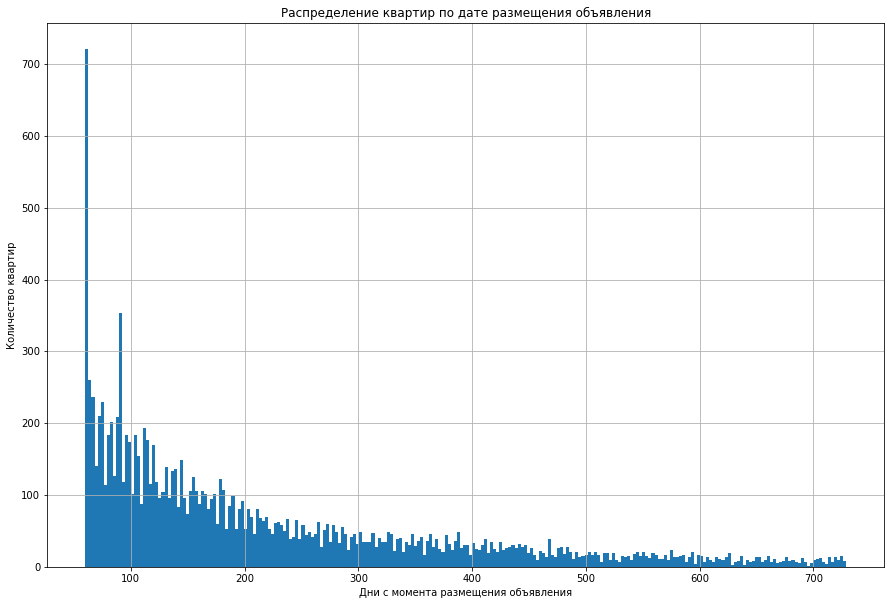

In [17]:
good_days_exposition['days_exposition'].hist(bins=250, figsize=(15, 10))
plt.xlabel('Дни с момента размещения объявления')
plt.ylabel('Количество квартир')
plt.title('Распределение квартир по дате размещения объявления')
plt.show()

В полученном списке среднее значение ниже, чем до фильтра: 218 дней (около 7 месяцев). Медиана, наоборот, выше: 162 дня (около 5 месяцев). Выделив срез данных, улучшили ситуацию с большой разницей между медианой и средним. Теперь влияние выбросов не такое сильное.

На ограниченной временными рамками от двух месяцев до двух лет гистограмме видны те же тенденции, что и на общей гистограмме: на  50 днях есть большой всплеск, а далее — спад.

Создадим срез по цене квартиры больше миллиона (потому что цены ниже нереалистичны). По этому срезу будем анализировать все дальнейшие параметры.

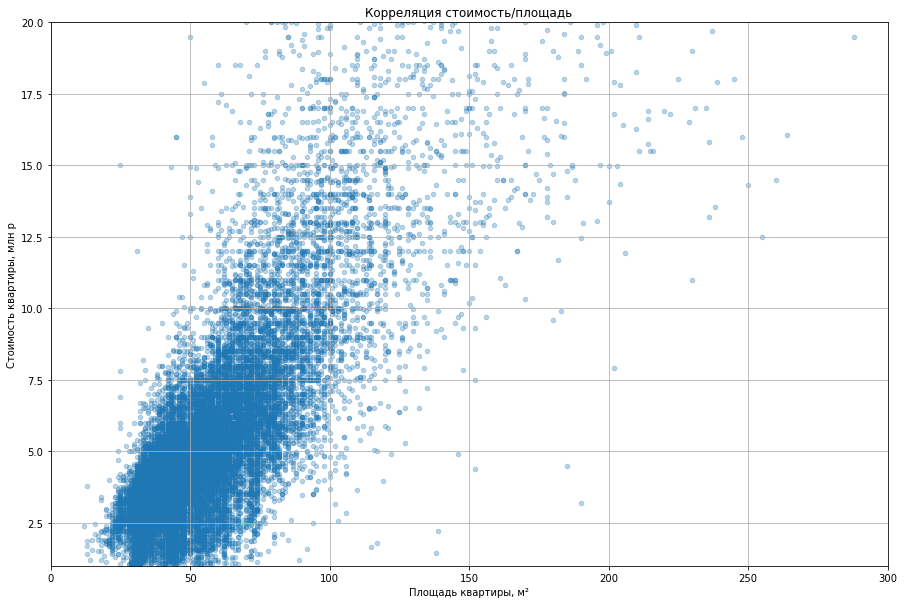

Коэффициент корреляции стоимость/площадь: 0.65


In [18]:
normal_price = real_estate_data.query('convenient_price > 1')
normal_price.plot(x='total_area', y='convenient_price', kind='scatter', ylim=(1, 20), xlim=(0, 300), alpha=0.3, figsize=(15, 10), grid=True)
plt.xlabel('Площадь квартиры, м²')
plt.ylabel('Стоимость квартиры, млн р')
plt.title('Корреляция стоимость/площадь')
plt.show()

print('Коэффициент корреляции стоимость/площадь:',
      normal_price['total_area'].corr(normal_price['convenient_price']).round(2))

Диаграмма рассеяния говорит о том, что в среднем чем больше квартира, тем она дороже, но не совсем. Если бы зависимость была прямо пропорциональной (точки лежали бы на прямой, идущей строго из левого нижнего угла строго в правый верхний), можно было бы сказать о том, что стоимость квартиры растет с ее площадью, но на самом деле — не только. Есть маленькие квартиры, стоящие как большие, и большие, стоящие как маленькие, но, как было сказано выше, в среднем большие квартиры дороже маленьких. Ровно то же самое нам говорит коэффициент корреляции (0.65): он довольно высокий, но все же не настолько, чтобы говорить о прямой зависимости величин.

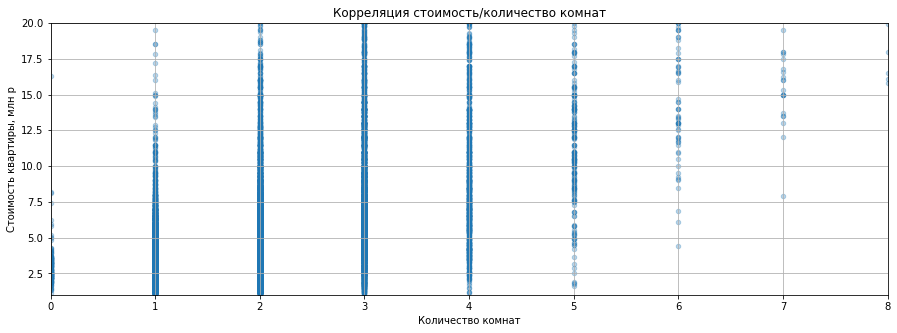

Коэффициент корреляции стоимость/количество комнат: 0.35


In [19]:
normal_price.plot(x='rooms', y='convenient_price', kind='scatter', ylim=(1, 20), xlim=(0, 8), alpha=0.3, figsize=(15, 5), grid=True)
plt.xlabel('Количество комнат')
plt.ylabel('Стоимость квартиры, млн р')
filtered_rooms = real_estate_data.query('rooms < 8')
plt.title('Корреляция стоимость/количество комнат')
plt.show()

print('Коэффициент корреляции стоимость/количество комнат:',
      filtered_rooms['rooms'].corr(normal_price['convenient_price']).round(2))

Коэффициент корреляции для стоимости и количества комнат довольно маленький (0.36).

Однако график показывает, что студии и квартиры со свободной планировкой чаще всего не стоят дороже 4 млн р, однокомнатные квартиры встречаются тем реже, чем выше цена, в диапазоне от 7.5 млн р. Далее, чем больше комнат, тем выше можно заметить точки, отмечающие стоимость. То есть, так же как и в случае с площадью квартиры, в среднем многокомнатные квартиры дороже малокомнатных, а еще многокомнатные квартиры в целом реже встречаются.

С трехкомнатными квартирами выведенная ценовая закономерность не работает: их много в любой ценовой категории. Это связано как с уже рассмотренной нами площадью квартиры, так и с другими факторами: этаж, расположение, состояние дома и др.

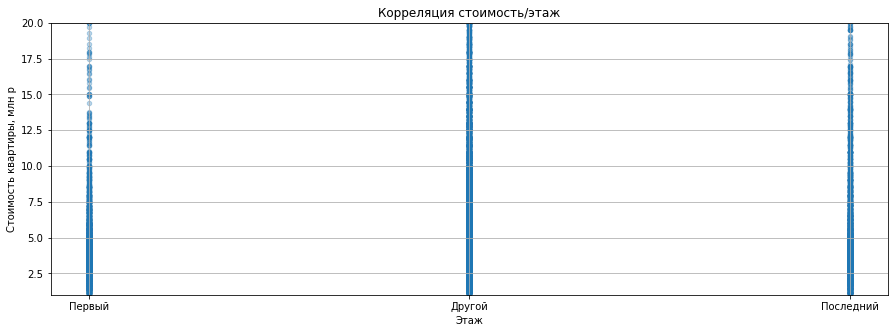

Коэффициент корреляции стоимость/этаж: 0.06


In [20]:
normal_price.plot(x='floor_grouped', y='convenient_price', kind='scatter', ylim=(1, 20), alpha=0.3, figsize=(15, 5), grid=True)
plt.xlabel('Этаж')
plt.ylabel('Стоимость квартиры, млн р')
plt.title('Корреляция стоимость/этаж')
plt.xticks([1, 2, 3],
           ['Первый', 'Другой', 'Последний'])
plt.show()

print('Коэффициент корреляции стоимость/этаж:',
      normal_price['floor_grouped'].corr(normal_price['convenient_price']).round(2))

Квартир на этажах кроме первого и последнего много в любой ценовой катрегории. Цены на квартиры на последнем этаже немного ниже, а на первом продавцы снижают цены довольно часто. У квартир на первых этажах может быть много неприятных особенностей: нижняя позиция в канализационной системе дома и вызванные этим проблемы с канализацией, сырой запах, тянущийся из подвала, куча соседей сверху, в панельках слышен звук подъездной двери, летом вас могут разбудить шумящие под окнами люди, в окно может постучать кто-то, якобы забывший ключ и умоляющий впустить в подъезд... На последних этажах люди иногда беспокоятся, что протечет крыша, но в хорошо спроектированных домах, не требующих капремонта, этой проблемы нет, тогда как проблемы первого этажа в той или иной степени есть всегда и везде.

Перед анализом необходимо немного подправить столбец `city_center_nearest`: будет гораздо удобнее, если расстояния будут выражены в километрах, округленных до целого числа.

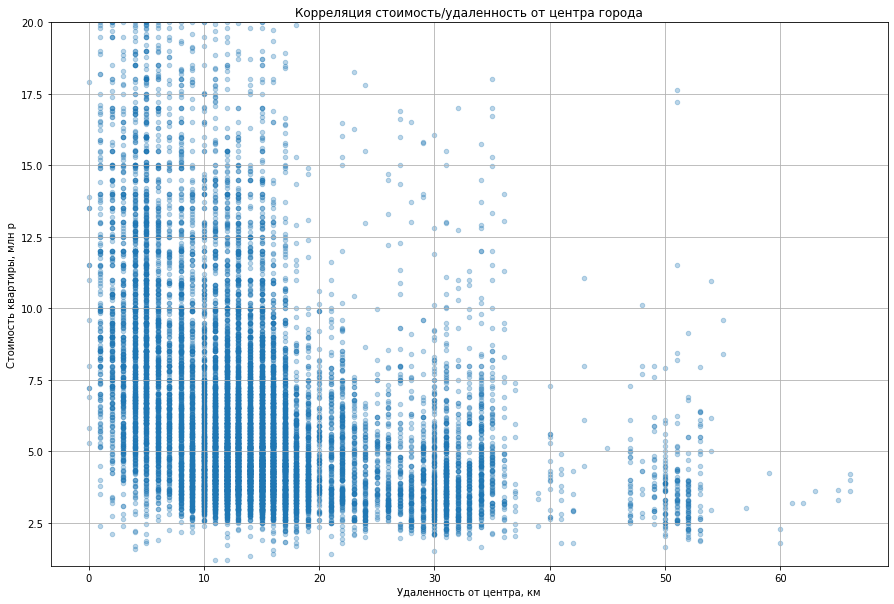

Коэффициент корреляции стоимость/удаленность от центра города: -0.21


In [21]:
normal_price['km_to_center'] = (normal_price['city_centers_nearest'] / 1000).round()

normal_price.plot(x='km_to_center', y='convenient_price', kind='scatter', ylim=(1, 20), alpha=0.3, figsize=(15, 10), grid=True)
plt.xlabel('Удаленность от центра, км')
plt.ylabel('Стоимость квартиры, млн р')
plt.title('Корреляция стоимость/удаленность от центра города')
plt.show()

print('Коэффициент корреляции стоимость/удаленность от центра города:',
      normal_price['km_to_center'].corr(normal_price['convenient_price']).round(2))

Коэффициент корреляции для удаленности от центра и стоимости квартиры близок к нулю (-0.21).

Диаграмма рассеяния для этих величин выглядит не так сомнительно, как коэффициент корреляции. Видно, что чем дальше от центра мы движемся, тем реже встречаются дорогие квартиры. Хотя на участке от 0 до 10 км до центра есть квартиры разных ценовых категорий.

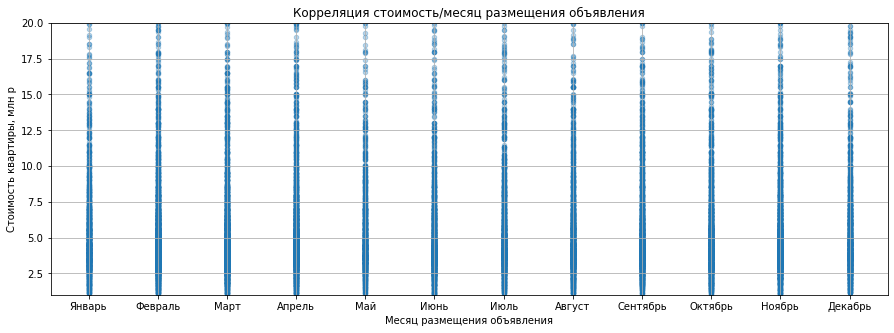

Коэффициент корреляции стоимость/месяц размещения объявления: 0.0


In [22]:
normal_price.plot(x='month_grouped', y='convenient_price', kind='scatter', ylim=(1, 20), alpha=0.3, figsize=(15, 5), grid=True)
plt.xlabel('Месяц размещения объявления')
plt.ylabel('Стоимость квартиры, млн р')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
           ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'])
plt.title('Корреляция стоимость/месяц размещения объявления')
plt.show()

print('Коэффициент корреляции стоимость/месяц размещения объявления:',
      normal_price['month_grouped'].corr(normal_price['convenient_price']).round(2))

В среднем наблюдается небольшое снижение цен летом, а в другие времена года цены на квартиры примерно одинаковые. Коэффициент корреляции просто невероятно маленький (0.002).

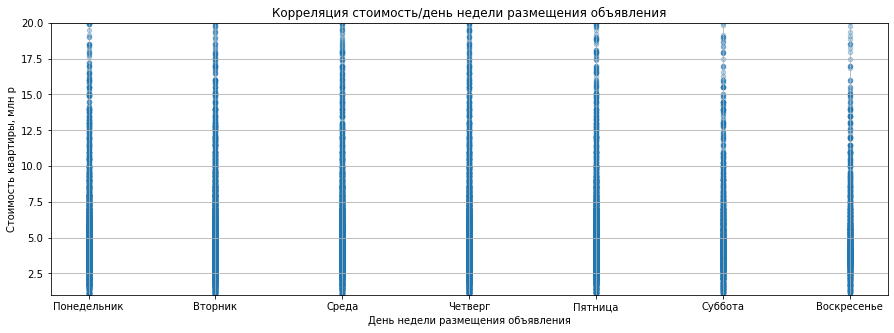

Коэффициент корреляции стоимость/день недели размещения объявления: 0.0


In [23]:
normal_price.plot(x='fde_weekday', y='convenient_price', kind='scatter', ylim=(1, 20), alpha=0.3, figsize=(15, 5), grid=True)
plt.xlabel('День недели размещения объявления')
plt.ylabel('Стоимость квартиры, млн р')
plt.xticks([0, 1, 2, 3, 4, 5, 6],
           ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'])
plt.title('Корреляция стоимость/день недели размещения объявления')
plt.show()

print('Коэффициент корреляции стоимость/день недели размещения объявления:',
      normal_price['fde_weekday'].corr(normal_price['convenient_price']).round(2))

Судя по графику, на выходных размещают меньше всего дорогих квартир. Небольшой спад цен есть и в понедельник и пятницу. В середине недели размещают квартиры любых ценовых категорий. Коэффициент Пирсона очень маленький (0.02).

Перед анализом по населенным пунктам необходимо настроить фильтрацию, так как в таблице существуют населенные пункты «Мурино», «поселок Мурино», «посёлок Мурино» и даже «поселок городского типа Мурино», и все это до фильтрации считается разными населенными пунктами.

Для начала избавимся от разногласий между «е» и «ё». После этого — от слов «поселок», «деревня», «село» и т.д.

Затем узнаем, в каких населенных пунктах больше всего объявлений о продаже квартир.

In [24]:
real_estate_data['locality_name'] = real_estate_data['locality_name'].str.replace('ё', 'е')
real_estate_data['locality_name'] = real_estate_data['locality_name'].str.replace('поселок ', '')
real_estate_data['locality_name'] = real_estate_data['locality_name'].str.replace('городского типа ', '')
real_estate_data['locality_name'] = real_estate_data['locality_name'].str.replace('городской ', '')
real_estate_data['locality_name'] = real_estate_data['locality_name'].str.replace('коттеджный ', '')
real_estate_data['locality_name'] = real_estate_data['locality_name'].str.replace('деревня ', '')
real_estate_data['locality_name'] = real_estate_data['locality_name'].str.replace('село ', '')
real_estate_data['locality_name'] = real_estate_data['locality_name'].str.replace('садовое товарищество ', '')
real_estate_data['locality_name'] = real_estate_data['locality_name'].str.replace('садоводческое некоммерческое товарищество ', '')
real_estate_data['locality_name'] = real_estate_data['locality_name'].str.replace('при железнодорожной станции ', '')
real_estate_data['locality_name'] = real_estate_data['locality_name'].str.replace('станции ', '')

top10 = real_estate_data['locality_name'].value_counts().head(10).index
top10 = real_estate_data[real_estate_data['locality_name'].isin(top10)]
 
top10.pivot_table(index='locality_name', values='square_meter_price', aggfunc='mean').sort_values(by='square_meter_price', ascending=False)

,square_meter_price
locality_name,
Санкт-Петербург,114871.190693
Пушкин,103170.629495
Кудрово,95366.345125
Парголово,90177.751321
Мурино,86098.442024
Шушары,78680.934791
Колпино,75448.492253
Гатчина,68724.579091
Всеволожск,68652.357487


Больше всего объявлений в Санкт-Петербурге, Пушкине, Кудрово, Парголово, Мурино, Шушарах, Колпино, Гатчине, Всеволожске и Выборге.

Среди самых широко представленых в таблице населенных пунктов самый дорогой квадратный метр в Санкт-Петербурге (почти 115 тыс/м²) и Пушкине (103 тыс/м²). Самые бюджетные квартиры в рассмотренном срезе находятся в Выборге (58 тыс/м²), Всеволожске и Гатчине (почти 69 тыс/м² у обоих).

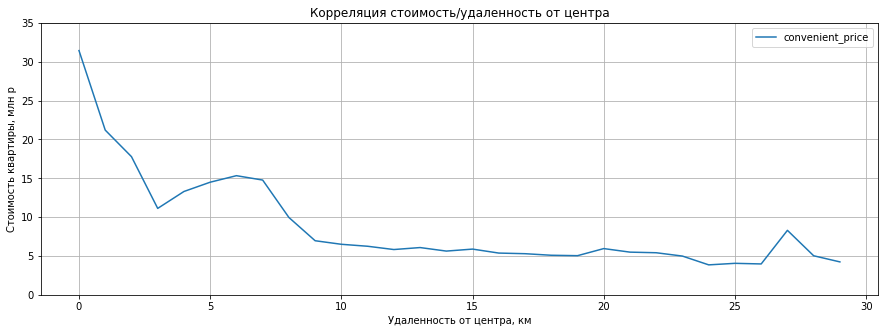

In [25]:
spb_real_estate = normal_price.query('locality_name in "Санкт-Петербург"')
spb_pivot = spb_real_estate.pivot_table(index='km_to_center', values='convenient_price', aggfunc='mean').sort_values(by='km_to_center')
spb_pivot.plot(ylim=(0, 35), figsize=(15, 5), grid=True)
plt.title('Корреляция стоимость/удаленность от центра')
plt.xlabel('Удаленность от центра, км')
plt.ylabel('Стоимость квартиры, млн р')
plt.show()

На графике видно, что внутри Санкт-Петербурга зависимость стоимости квартиры от ее удалености от центра прослеживается лучше, чем на общей для всей Ленинградской области диаграмме рессеяния. Близко к центру на графике есть видимый провал на уровне 3 км, так же, как на уровне 27 км есть видимый скачок. Это не похоже на логически обусловленные провалы и скачки, скорее на выбросы. А вот резкий рост цены при движении от дальних километров к ближним, начинающийся на 9 км от центра, уже похож на рост цены, связанный с тем, что квартира находится рядом с центром города.

In [26]:
center = spb_real_estate.query('km_to_center < 9')
center['total_area'].describe()

count    4122.000000
mean       90.323144
std        58.885977
min        12.000000
25%        55.000000
50%        76.000000
75%       107.000000
max       900.000000
Name: total_area, dtype: float64

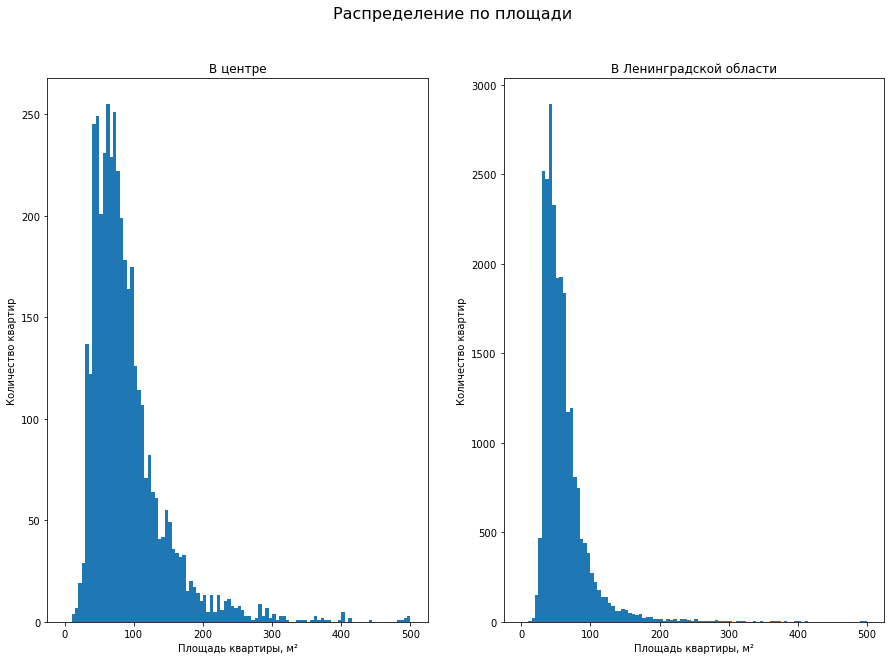

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax1.hist(center['total_area'], bins=100, range=(0, 500))
ax1.set_title('В центре')
ax1.set_xlabel('Площадь квартиры, м²')
ax1.set_ylabel('Количество квартир')

ax2.hist(real_estate_data['total_area'], bins=100, range=(0, 500))
ax2.set_xlabel('Площадь квартиры, м²')
ax2.set_ylabel('Количество квартир')
ax2.set_title('В Ленинградской области')

fig.suptitle('Распределение по площади', fontsize=16)
plt.show()

В центре Санкт-Петербурга находится 4122 квартиры из 23699, представленных в таблице. Здесь встречаются квартиры площадью от 12 до 900 м², как и в таблице со всеми квартирами. Среднее значение площади в центре — 90 м², медиана — 76 м², что больше среднего и медианы по всей Ленинградской области (то есть, квартиры в центре Петербурга в среднем больше квартир в других точках Ленинградской области).

In [28]:
center['convenient_price'].describe()

count    4122.000000
mean       14.180373
std        23.580489
min         1.600000
25%         6.450000
50%         8.960000
75%        13.900000
max       763.000000
Name: convenient_price, dtype: float64

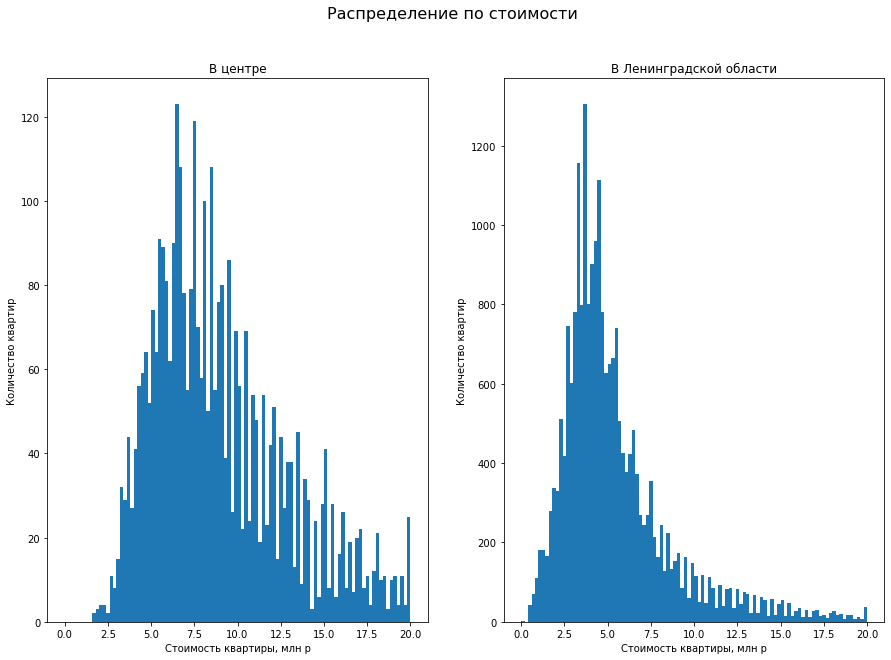

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax1.hist(center['convenient_price'], bins=100, range=(0, 20))
ax1.set_title('В центре')
ax1.set_xlabel('Стоимость квартиры, млн р')
ax1.set_ylabel('Количество квартир')

ax2.hist(real_estate_data['convenient_price'], bins=100, range=(0, 20))
ax2.set_xlabel('Стоимость квартиры, млн р')
ax2.set_ylabel('Количество квартир')
ax2.set_title('В Ленинградской области')

fig.suptitle('Распределение по стоимости', fontsize=16)
plt.show()

В срезе по центру встречаются квартиры от 1.6 до 763 млн р. Разброс меньше, чем у общей таблицы, но верхняя граница осталась на месте, значит самые дорогие квартиры из общей таблицы находятся именно в центре Петербурга. Среднее значение цены в срезе — 14 млн р, медиана — почти 9 млн р. Разница говорит о выбросах с огромными ценами. Об этом же говорит факт, что 75% квартир стоят меньше 14 млн р.

Гистограмма отличается от общей: здесь разница в количестве квартир за 20 млн и за 7 хоть и видна невооруженным взглядом, но не настолько огромна, как на общей гистограмме.

In [30]:
center['rooms'].describe()

count    4122.000000
mean        2.757885
std         1.426035
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max        19.000000
Name: rooms, dtype: float64

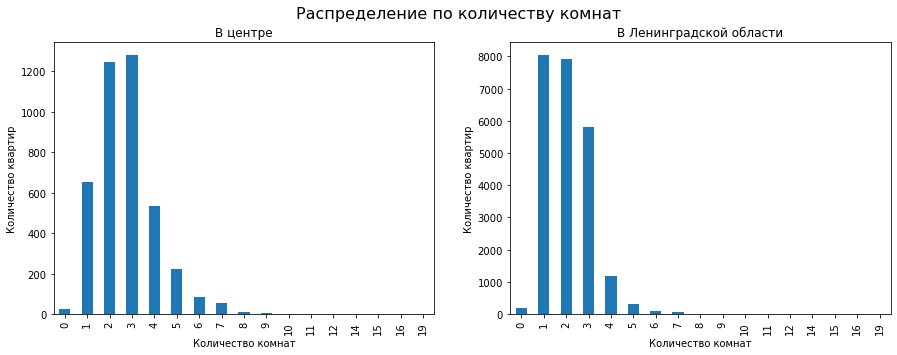

In [31]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 5))

center_bar = center['rooms'].value_counts().sort_index().plot.bar(ax=axarr[0])

center_bar.set_title('В центре')
center_bar.set_xlabel('Количество комнат')
center_bar.set_ylabel('Количество квартир')

total_bar = real_estate_data['rooms'].value_counts().sort_index().plot.bar(ax=axarr[1])
total_bar.set_xlabel('Количество комнат')
total_bar.set_ylabel('Количество квартир')
total_bar.set_title('В Ленинградской области')

fig.suptitle('Распределение по количеству комнат', fontsize=16)
plt.show()

Максимальное число комнат в срезе по центру все еще 19. Среднее и медиана близки, как и в общей таблице, но они больше: 2.76 и 3 комнаты соответственно. Значит, квартиры в центре не только в среднем больше не только по площади, но и по кличеству комнат.

Распределение в срезе сильно отличается от общего. В центре Петербурга большинство квартир — трешки и двушки, а однокомнатных квартир, студий и квартир с открытой планировкой относительно мало, как и квартир с большим количеством комнат.

In [32]:
center['ceiling_height'].describe()

count    2687.000000
mean        3.130636
std         2.122037
min         2.000000
25%         2.800000
50%         3.000000
75%         3.250000
max       100.000000
Name: ceiling_height, dtype: float64

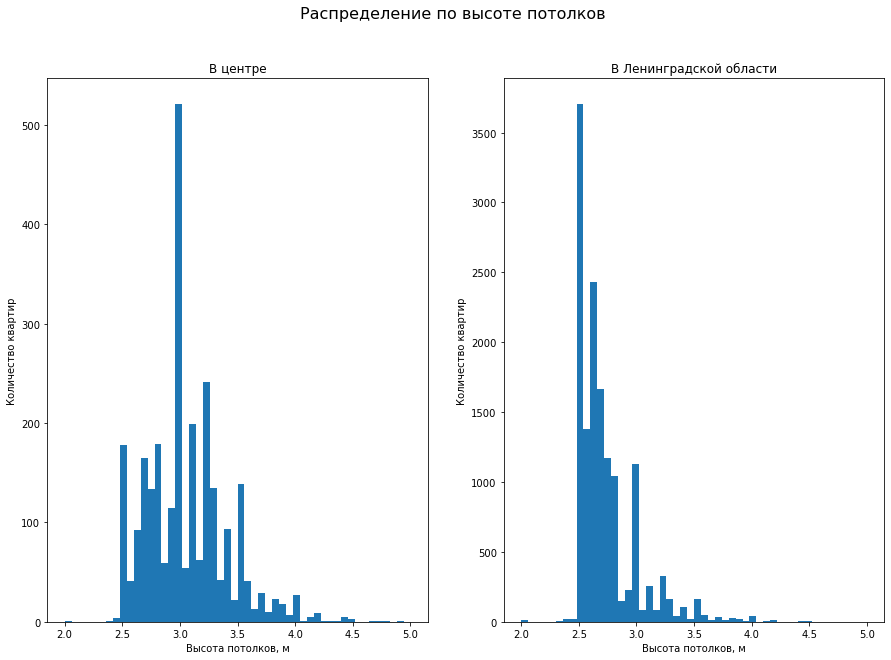

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax1.hist(center['ceiling_height'], bins=50, range=(2, 5))
ax1.set_title('В центре')
ax1.set_xlabel('Высота потолков, м')
ax1.set_ylabel('Количество квартир')

ax2.hist(real_estate_data['ceiling_height'], bins=50, range=(2, 5))
ax2.set_xlabel('Высота потолков, м')
ax2.set_ylabel('Количество квартир')
ax2.set_title('В Ленинградской области')

fig.suptitle('Распределение по высоте потолков', fontsize=16)
plt.show()

Минимальная заявленная высота потолка в центре Петербурга — 2 м. Уже лучше, чем 1, но все еще непохоже на правду. Квартира со стометровым потолком тоже здесь. Среднее по срезу значение — 3.13 м, медиана — 3 м.

Гистограмма по центру совсем не похожа на гистограмму по всей Ленинградской области. В центре Петербурга большинство квартир — в «сталинках» и других довольно старых домах с высотой потолков в 3 м.

Коэффициент корреляции для центра: 0.34
Общий коэффициент корреляции: 0.36


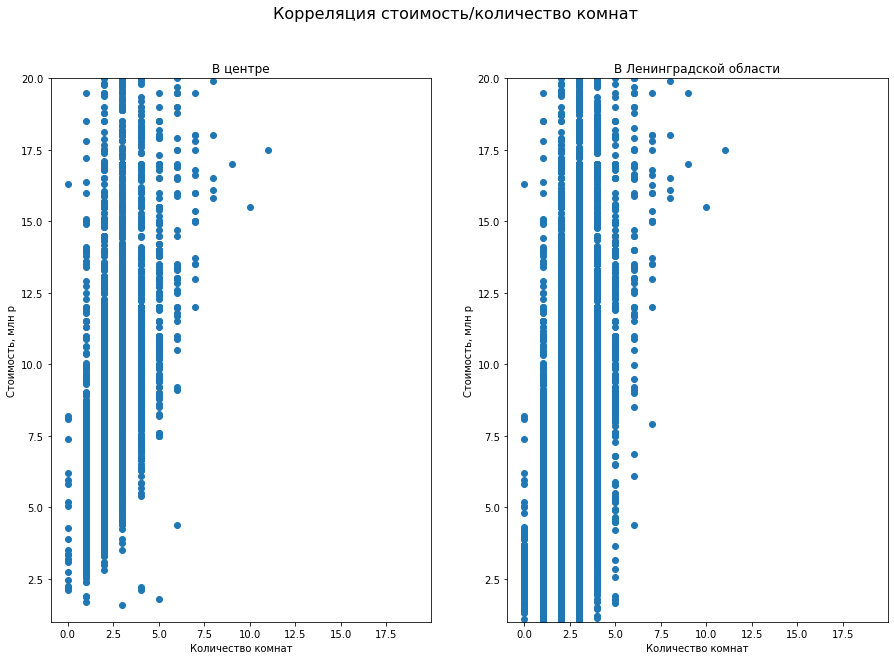

In [34]:
print('Коэффициент корреляции для центра:', center['rooms'].corr(center['convenient_price']).round(2))
print('Общий коэффициент корреляции:', normal_price['rooms'].corr(normal_price['convenient_price']).round(2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax1.scatter(center['rooms'], center['convenient_price'])
ax1.set_ylim([1, 20])
ax1.set_title('В центре')
ax1.set_xlabel('Количество комнат')
ax1.set_ylabel('Стоимость, млн р')

ax2.scatter(normal_price['rooms'], normal_price['convenient_price'])
ax2.set_ylim([1, 20])
ax2.set_xlabel('Количество комнат')
ax2.set_ylabel('Стоимость, млн р')
ax2.set_title('В Ленинградской области')

fig.suptitle('Корреляция стоимость/количество комнат', fontsize=16)
plt.show()

Коэффициент корреляции для центра: 0.1
Общий коэффициент корреляции: 0.06


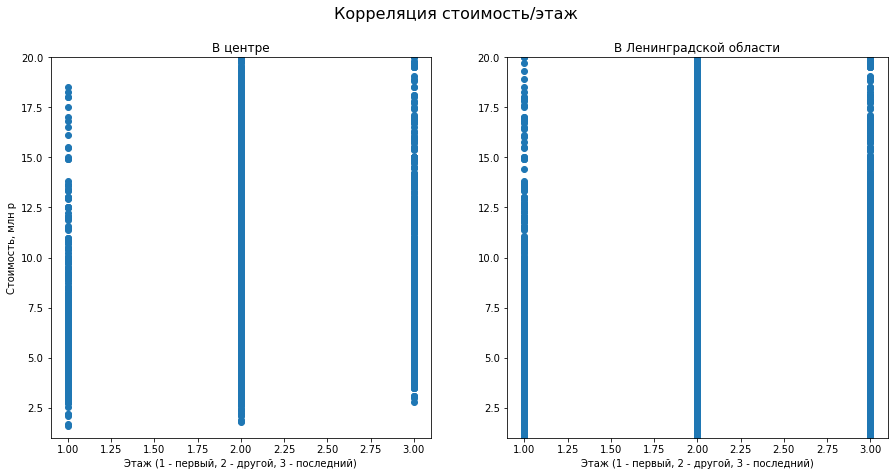

In [35]:
print('Коэффициент корреляции для центра:', center['floor_grouped'].corr(center['convenient_price']).round(2))
print('Общий коэффициент корреляции:', normal_price['floor_grouped'].corr(normal_price['convenient_price']).round(2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.scatter(center['floor_grouped'], center['convenient_price'])
ax1.set_ylim([1, 20])
ax1.set_title('В центре')
ax1.set_xlabel('Этаж (1 - первый, 2 - другой, 3 - последний)')
ax1.set_ylabel('Стоимость, млн р')

ax2.scatter(normal_price['floor_grouped'], normal_price['convenient_price'])
ax2.set_ylim([1, 20])
ax2.set_xlabel('Этаж (1 - первый, 2 - другой, 3 - последний)')
ax2.set_title('В Ленинградской области')

fig.suptitle('Корреляция стоимость/этаж', fontsize=16)
plt.show()

Точно так же: диаграмма для среза по центру Петербурга очень похожа на такую же общую, однако квартир в сегменте дешевле 2.5 млн в центре Петербурга мало. Коэффициент пирсона в сравнении с коэффициентом для всей Ленинградской области вырос вдвое (но все еще остался маленьким: 0.1).

Коэффициент корреляции для центра: -0.08
Общий коэффициент корреляции: -0.21


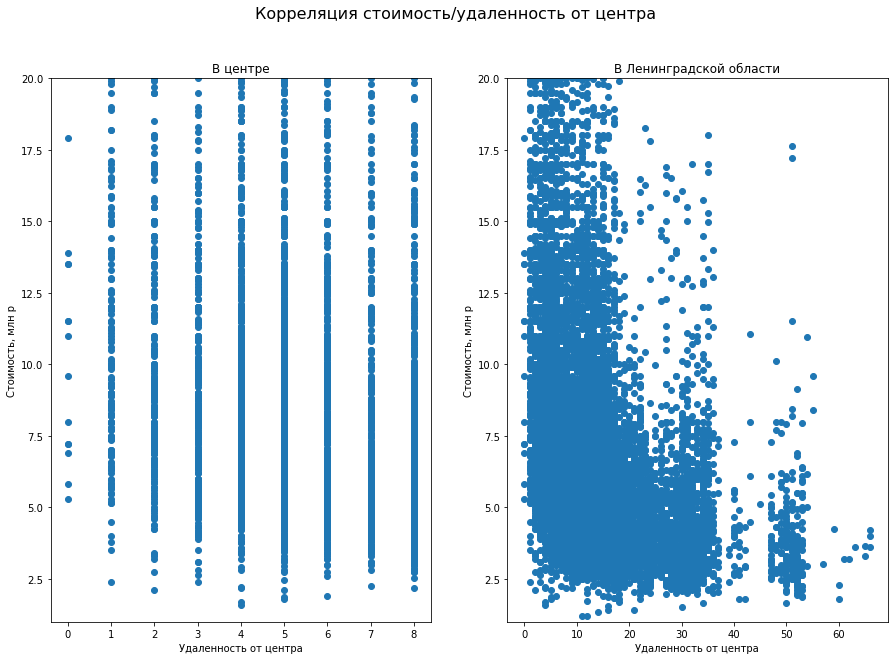

In [36]:
print('Коэффициент корреляции для центра:', center['km_to_center'].corr(center['convenient_price']).round(2))
print('Общий коэффициент корреляции:', normal_price['km_to_center'].corr(normal_price['convenient_price']).round(2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax1.scatter(center['km_to_center'], center['convenient_price'])
ax1.set_ylim([1, 20])
ax1.set_title('В центре')
ax1.set_xlabel('Удаленность от центра')
ax1.set_ylabel('Стоимость, млн р')

ax2.scatter(normal_price['km_to_center'], normal_price['convenient_price'])
ax2.set_ylim([1, 20])
ax2.set_xlabel('Удаленность от центра')
ax2.set_ylabel('Стоимость, млн р')
ax2.set_title('В Ленинградской области')

fig.suptitle('Корреляция стоимость/удаленность от центра', fontsize=16)
plt.show()

Коэффициент корреляции для удаленности от центра и стоимости квартиры в срезе по центру Петербурга сильно упал в сравнении с общим коэффициентом (стал меньше -0.1). Неудивительно, потому что какую бы квартиру в срезе мы ни взяли, она будет в центре, а значит ее стоимость будет в основном зависеть от других факторов.

На диаграмме видно, что зависимость все же есть, хоть и слабая: скопления точек по более удаленным от центра квартиры находятся немного ниже скоплений точек в 3-4 км от центра. Скоплений точек в 0-1 км от центра мало, потому что и квартир там продается мало.

Коэффициент корреляции для центра: -0.0
Общий коэффициент корреляции: 0.0


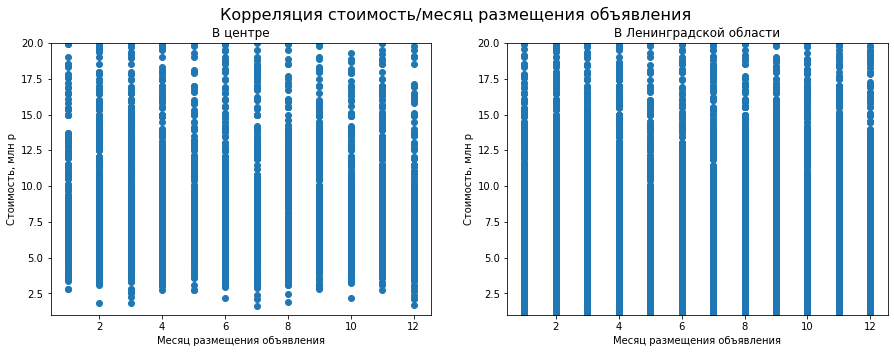

In [38]:
print('Коэффициент корреляции для центра:', center['month_grouped'].corr(center['convenient_price']).round(2))
print('Общий коэффициент корреляции:', normal_price['month_grouped'].corr(normal_price['convenient_price']).round(2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.scatter(center['month_grouped'], center['convenient_price'])
ax1.set_ylim([1, 20])
ax1.set_title('В центре')
ax1.set_xlabel('Месяц размещения объявления')
ax1.set_ylabel('Стоимость, млн р')

ax2.scatter(normal_price['month_grouped'], normal_price['convenient_price'])
ax2.set_ylim([1, 20])
ax2.set_xlabel('Месяц размещения объявления')
ax2.set_ylabel('Стоимость, млн р')
ax2.set_title('В Ленинградской области')

fig.suptitle('Корреляция стоимость/месяц размещения объявления', fontsize=16)
plt.show()

Как и в ситуации с количеством комнат и этажами: диаграммы рассеяния для  месяца размещения объявления выглядит почти так же, как общая, за исключением того, что в диаграмме по срезу квартиры в ценовой категории до 2.5 млн почти не фигурируют. Коэффициент корреляции для этих величин нулевой.

## Общий вывод

На стоимость квартиры больше всего влияют ее размер (как с комнатах так и в квадратных метрах), а также расположение. Самые дорогие квартиры в Ленинградской области — в цетре Петербурга, самые недорогие — в Выборге, Всеволожске и Гатчине.

В меньшей степени влияет на стоимость квартиры этаж: на первых этажах квартиры дешевле, как и на последних (но последний этаж не так сильно удешевляет квартиру, как первый).

В очень малой степени на стоимость квартиры влияет время размещения объявления.

В центре города главный влияющий фактор тот же — размер квартиры. При этом очень большие квартиры при своей дороговизне встречаются в общем довольно редко, а чаще всего в центре Петербурга встречаются двухкомнатные и трехкомнатные квартиры, а в среднем по Ленинградской области — однокомнатные.